In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import plotly.express as px

DATA = Path("../data/processed/analytics_table.parquet")
FIGS = Path("../reports/figures")
FIGS.mkdir(parents=True, exist_ok=True)

def save_fig(fig, path: Path, *, scale: int = 2) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)
    fig.write_image(str(path), scale=scale)

In [2]:
#Task2
df = pd.read_parquet(DATA)

print("rows:", len(df), "cols:", len(df.columns))
print(df.dtypes.head(15))
print(df.isna().sum().sort_values(ascending=False).head(10))

rows: 5 cols: 18
order_id               string[python]
user_id                string[python]
amount                        Float64
quantity                        Int64
created_at        datetime64[ns, UTC]
status                         object
status_clean                   object
amount__isna                     bool
quantity__isna                   bool
date                           object
year                          float64
month                  string[python]
dow                            object
hour                          float64
country                        object
dtype: object
quantity              1
amount                1
amount__is_outlier    1
amount_winsor         1
created_at            1
date                  1
hour                  1
dow                   1
month                 1
year                  1
dtype: int64


In [3]:
#Helper Columns
if "month" not in df.columns and "created_at" in df.columns:
    dt = pd.to_datetime(df["created_at"], errors="coerce", utc=True)
    df["month"] = dt.dt.to_period("M").astype("string")

if "amount_winsor" not in df.columns and "amount" in df.columns:
    lo, hi = df["amount"].quantile([0.01, 0.99])
    df["amount_winsor"] = df["amount"].clip(lo, hi)

  country  n  revenue     aov
1      SA  4    145.5  36.375
0      AE  1      0.0    <NA>


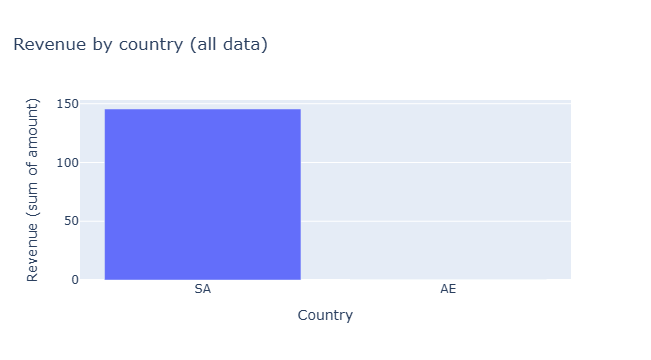

In [4]:
#Revenue by Country
rev = (
    df.groupby("country", dropna=False)
      .agg(n=("order_id", "size"), revenue=("amount", "sum"), aov=("amount", "mean"))
      .reset_index()
      .sort_values("revenue", ascending=False)
)

print(rev)

fig = px.bar(rev, x="country", y="revenue", title="Revenue by country (all data)")
fig.update_layout(title={"x": 0.02})
fig.update_xaxes(title_text="Country")
fig.update_yaxes(title_text="Revenue (sum of amount)")
save_fig(fig, FIGS / "revenue_by_country.png")
fig.show()

     month  n  revenue
0  2025-12  4     45.5
1     <NA>  1    100.0


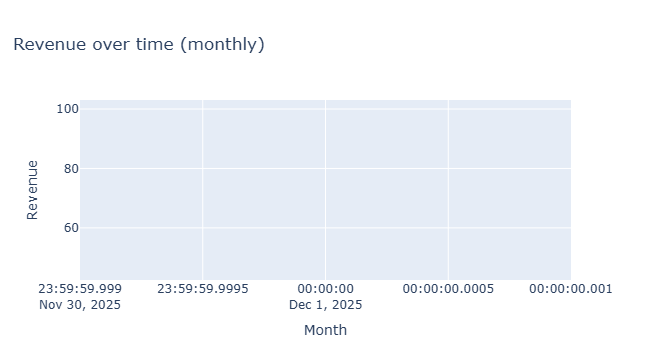

In [8]:
#Revenue Trend
trend = (
    df.groupby("month", dropna=False)
      .agg(n=("order_id", "size"), revenue=("amount", "sum"))
      .reset_index()
      .sort_values("month")
)

print(trend)

fig = px.line(trend, x="month", y="revenue", title="Revenue over time (monthly)")
fig.update_layout(title={"x": 0.02})
fig.update_xaxes(title_text="Month")
fig.update_yaxes(title_text="Revenue")
save_fig(fig, FIGS / "revenue_trend_monthly.png")
fig.show()

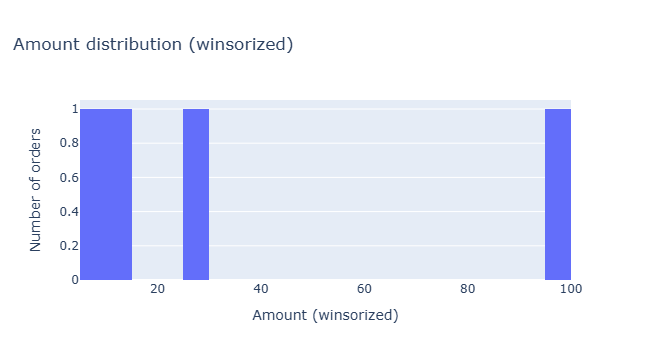

In [6]:
#Amount Distribution
fig = px.histogram(df, x="amount_winsor", nbins=30, title="Amount distribution (winsorized)")
fig.update_layout(title={"x": 0.02})
fig.update_xaxes(title_text="Amount (winsorized)")
fig.update_yaxes(title_text="Number of orders")
save_fig(fig, FIGS / "amount_hist_winsor.png")
fig.show()

In [7]:
# Bootstrap Comparison
def bootstrap_diff_means(a: pd.Series, b: pd.Series, *, n_boot: int = 2000, seed: int = 0):
    rng = np.random.default_rng(seed)
    a = pd.to_numeric(a, errors="coerce").dropna().to_numpy()
    b = pd.to_numeric(b, errors="coerce").dropna().to_numpy()
    assert len(a) > 0 and len(b) > 0

    diffs = []
    for _ in range(n_boot):
        sa = rng.choice(a, size=len(a), replace=True)
        sb = rng.choice(b, size=len(b), replace=True)
        diffs.append(sa.mean() - sb.mean())
    diffs = np.array(diffs)

    return {
        "diff_mean": float(a.mean() - b.mean()),
        "ci_low": float(np.quantile(diffs, 0.025)),
        "ci_high": float(np.quantile(diffs, 0.975)),
    }

d = df.assign(is_refund=df["status_clean"].eq("refund").astype(int))

a = d.loc[d["country"].eq("SA"), "is_refund"]
b = d.loc[d["country"].eq("AE"), "is_refund"]

print("n_SA:", len(a), "n_AE:", len(b))
res = bootstrap_diff_means(a, b, n_boot=2000, seed=0)
print(res)

n_SA: 4 n_AE: 1
{'diff_mean': -1.0, 'ci_low': -1.0, 'ci_high': -1.0}
